In [1]:
from numpy import array
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas import read_csv
from math import sqrt

from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# split a univariate sequence into samples

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequence(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# fixem random seed
np.random.seed(7)

dadesSau = read_csv('dadesBaells.csv', sep=';',header=0, index_col=0)
dataframe = pd.DataFrame(dadesSau.loc[dadesSau.index >= '2009-01-01']['Volum'])
dataset = dataframe.values
dataset = dataset.astype('float32')

# Normalitzem

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = [item for sublist in dataset for item in sublist]

n_steps_in = 20
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, dataset)

In [2]:
from scipy.stats import uniform
from scipy.stats import randint
c=[]
epsilon=[]
gamma=[]

for i in range(500):
    c.append((randint.rvs(5, 125)))
    epsilon.append(round(uniform.rvs(0.0001, 0.1),4))
    gamma.append(round(uniform.rvs(0.01, 0.9),4))

In [3]:
#Simulació RandomizedSearchCV per SVM
resultat=[]

for c_v, eps, gam in zip(c, epsilon, gamma):
    regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=c_v, gamma=gam, epsilon=eps))
    regr_multisvr.fit(train_X, train_Y)
    # Predict on new data
    testPredict = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    testPredict = scaler.inverse_transform(testPredict)
    test_YR = scaler.inverse_transform(test_Y)

    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(c_v, gam, eps, RMSE_TOT)
    resultat.append((c_v, gam, eps, RMSE_days,RMSE_TOT))


52 0.2971 0.0228 4.019513818249837
88 0.8902 0.0724 16.737435008321455
19 0.0881 0.0265 2.7912257243719103
47 0.4599 0.0269 6.403990557639767
73 0.3078 0.087 6.721451728265058
5 0.2693 0.0067 2.967731693035041
24 0.3214 0.0695 5.422017513276182
61 0.0324 0.0932 3.5846807989359615
66 0.2173 0.0951 5.315365343293064
83 0.8539 0.0792 15.316531846459352
92 0.6854 0.0524 16.74895219716955
53 0.1004 0.0194 2.6990407647300536
36 0.3451 0.0492 5.590931177872131
76 0.2589 0.035 4.5302756134168645
69 0.2926 0.077 6.246314824391803
124 0.0852 0.0144 2.668307245945079
102 0.6017 0.0354 13.552775706607122
24 0.4 0.0922 6.567370528827718
35 0.7242 0.0987 12.10104677524343
86 0.3901 0.0742 9.765142809813309
55 0.6013 0.0624 14.003481834247316
80 0.0113 0.0416 2.802990778125276
98 0.7136 0.0441 17.13487809030557
72 0.8699 0.0697 16.668555732778472
58 0.1484 0.0955 4.422076345615248
53 0.2216 0.0594 4.4438131463329
59 0.7736 0.0946 13.653390019126364
55 0.7647 0.0663 15.563975931647315
81 0.4267 0.031 

53 0.2493 0.011 3.563012570419527
123 0.8731 0.0731 17.267379838566367
54 0.2172 0.0423 3.843433329556176
9 0.7234 0.0436 7.34293997983723
22 0.5307 0.0265 5.828450596142161
92 0.1576 0.0839 4.367403649046347
66 0.2967 0.0868 6.33377392082522
69 0.705 0.0293 12.742639120341089
62 0.2408 0.0485 4.549083076142456
6 0.8287 0.0799 9.386770860016888
111 0.4526 0.0413 10.507369169051584
24 0.5482 0.0683 9.436039094754163
109 0.1281 0.0764 3.8173063941509313
68 0.2394 0.0671 5.2842301665475935
6 0.2133 0.0636 3.375996476479856
15 0.1501 0.0677 3.328590345108615
15 0.2527 0.0753 4.305894008249916
115 0.3818 0.0876 10.171002169504543
35 0.5956 0.0982 10.924846295983684
77 0.6477 0.0056 9.081389509277239
46 0.2628 0.0985 5.643916608367294
104 0.2383 0.0807 5.85346890840355
111 0.5673 0.0827 16.261969292383004
34 0.2867 0.0556 4.909924183709203
117 0.9032 0.0002 19.179614380358174
41 0.1515 0.0132 2.7611491287704344
100 0.379 0.0077 6.003031947103005
72 0.7308 0.022 12.413690131677221
118 0.1556 

72 0.1436 0.0208 2.7884349921029985
62 0.0757 0.0882 3.768889390398928
63 0.8963 0.062 17.404480808066275
116 0.599 0.0595 16.995022375282577
99 0.5127 0.0648 15.050247736119962
5 0.2701 0.0903 4.419472151943987
95 0.1966 0.0377 3.871318494299014
106 0.0478 0.0527 2.898856750989287
41 0.0119 0.0295 2.8128180544469172
106 0.6203 0.0697 16.901361916821333
45 0.7695 0.0296 11.784854908774594
98 0.251 0.0484 5.347511600957991
79 0.1508 0.0396 3.0391445966187973
31 0.7283 0.0699 13.638854061885024
112 0.4475 0.0894 12.588944180898054
5 0.6666 0.0593 6.769688097869692
86 0.1891 0.04 3.715655048298317
120 0.6904 0.0863 15.263673902147437
104 0.3233 0.0872 7.846648633776154
112 0.6085 0.0227 12.258080297182449
11 0.0752 0.0792 3.410892763956903
69 0.8495 0.0315 16.215366305558437
80 0.7123 0.0709 16.238220744369414
52 0.7836 0.0812 14.473213112251
40 0.2353 0.0893 5.0707576982148925
6 0.1592 0.0025 2.826506264228858
99 0.558 0.0354 12.283269662029944
78 0.8029 0.0444 17.366708978513937
43 0.41

In [4]:
varlist = []
for i in range(len(c)):
    varlist.append(resultat[i])
    
resultFinal = pd.DataFrame(varlist)
resultFinal.columns=['C','gamma',  'epsilon','RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]


,C,gamma,epsilon,RMSE_dies,RMSE_total
0,124,0.0852,0.0144,"[0.5842581497696612, 0.8465135990208356, 1.158...",2.668307
1,77,0.0934,0.0123,"[0.5268966674630029, 0.8351742323392207, 1.147...",2.686013
2,105,0.1157,0.0146,"[0.7376703211343709, 0.9041780773077094, 1.161...",2.692777
3,64,0.0920,0.0128,"[0.5247442777194805, 0.8343272358616713, 1.152...",2.695926
4,53,0.1004,0.0194,"[0.7085743647648114, 0.9023592997488441, 1.194...",2.699041
5,87,0.1176,0.0288,"[0.7904659777416919, 1.1087995159999646, 1.249...",2.725303
6,59,0.1153,0.0310,"[0.8631780787098249, 1.1092590298810892, 1.275...",2.727944
7,76,0.0978,0.0023,"[0.5644331005733922, 0.8936190034054543, 1.155...",2.728706
8,69,0.0900,0.0368,"[0.9950964483265291, 1.1743802507417558, 1.353...",2.748117
9,118,0.0673,0.0363,"[0.9356555594528833, 1.145010367786081, 1.3237...",2.748278


In [5]:
import numpy as np
n_steps_in = np.arange(5,101,2)
resultat = []
for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, dataset)
    regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=124, gamma=0.0852, epsilon=0.0144))
    regr_multisvr.fit(train_X, train_Y)
    # Predict on new data
    testPredict = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    testPredict = scaler.inverse_transform(testPredict)
    test_YR = scaler.inverse_transform(test_Y)

    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

2.983740640673014 5
2.8891665475329438 7
2.843388949037153 9
2.8377421046049567 11
2.8148795631759684 13
2.7939639527423084 15
2.7364396790336536 17
2.7006661589367997 19
2.652566553983383 21
2.6238548304620464 23
2.6151017458693997 25
2.623088501718163 27
2.678516545532234 29
2.7435715101511375 31
2.8074371260456203 33
2.893555301877732 35
3.0636600288902347 37
3.282893836051519 39
3.6355972664694076 41
4.129195382180214 43
4.683880787800981 45
5.519568086942062 47
6.258407801275451 49
6.930508483336216 51
7.483616472854075 53
7.94133591486035 55
8.47909639978935 57
8.913409830380095 59
9.447717734518509 61
10.016918772994222 63
10.605749495365188 65
11.26412956804274 67
11.882155751277073 69
12.284095801122405 71
12.58202362406237 73
12.846738953920418 75
12.945352669836229 77
13.179015910826706 79
13.26321675326065 81
13.342221303993123 83
13.32775415107449 85
13.387246990313486 87
13.615660446298156 89
13.743007530533923 91
13.928871403216283 93
14.055786237601819 95
14.34349286982

In [6]:
import numpy as np
n_steps_in = [24,25,26]
resultat = []
for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, dataset)
    regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf',  C=124, gamma=0.0852, epsilon=0.0144))
    regr_multisvr.fit(train_X, train_Y)
    # Predict on new data
    testPredict = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    testPredict = scaler.inverse_transform(testPredict)
    test_YR = scaler.inverse_transform(test_Y)

    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

2.614169086033149 24
2.6151017458693997 25
2.6198368190731816 26


In [7]:
import numpy as np
n_steps_in =24
train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, dataset)
regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf',  C=124, gamma=0.0852, epsilon=0.0144))
regr_multisvr.fit(train_X, train_Y)
# Predict on new data
testPredict = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
testPredict = scaler.inverse_transform(testPredict)
test_YR = scaler.inverse_transform(test_Y)

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)

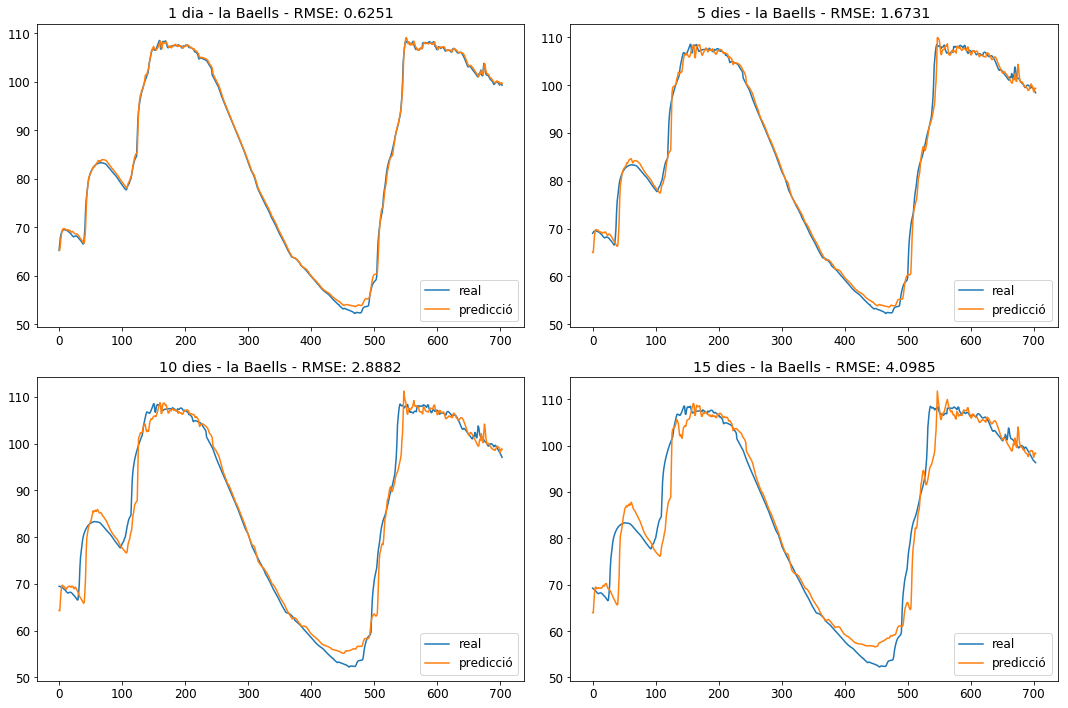

In [8]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_days[0],4))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_days[4],4))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_days[9],4))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_days[14],4))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

In [9]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

print(RMSE_days)
headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

[0.6250899561945664, 0.8208487194114933, 1.1572587783249417, 1.4339450410186587, 1.673076427226905, 1.9493151594461675, 2.1829576440312, 2.404681954945692, 2.61195505251577, 2.888223084169877, 3.116896601238273, 3.3686405842933174, 3.6057350806358723, 3.914104827508363, 4.098526159540157]
╒═════════╤══════════╤═════════╤═════════╤═════════╕
│   dia 1 │    dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞═════════╪══════════╪═════════╪═════════╪═════════╡
│ 0.62509 │ 0.820849 │ 1.15726 │ 1.43395 │ 1.67308 │
╘═════════╧══════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 1.94932 │ 2.18296 │ 2.40468 │ 2.61196 │  2.88822 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪═

In [10]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts_rquad(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        r_quad = r2_score(actual[:, i], predicted[:, i])
        mae = mean_absolute_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append((rmse,r_quad,mae,mse))
    # calcul global de RMSE
    s = 0
    r = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [11]:
RMSE_TOT, RMSE_days = evaluate_forecasts_rquad(test_YR,testPredict)
global_y = test_YR.reshape((test_YR.shape[0]*test_YR.shape[1], 1))
global_pred = testPredict.reshape((testPredict.shape[0]*testPredict.shape[1], 1))
r_quad = r2_score(global_y, global_pred)
rmse = sqrt(mean_squared_error(global_y, global_pred))
mse = mean_squared_error(global_y, global_pred)
mae = mean_absolute_error(global_y, global_pred)

res_globals=[rmse, r_quad, mae, mse]

resultsDF =  pd.DataFrame(RMSE_days)
resultsDF = resultsDF.T
resultsDF['Global'] = res_globals
resultsDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
resultsDF.rename(index={0:'RMSE',1:'R2',2:'MAE', 3:'MSE'}, inplace=True)
resultsDF = resultsDF.round(4)
display(resultsDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,0.6251,0.8208,1.1573,1.4339,1.6731,1.9493,2.1830,2.4047,2.6120,2.8882,3.1169,3.3686,3.6057,3.9141,4.0985,2.6198
R2,0.9989,0.9982,0.9963,0.9944,0.9923,0.9896,0.9869,0.9841,0.9813,0.9771,0.9733,0.9688,0.9642,0.9578,0.9537,0.9812
MAE,0.4461,0.5033,0.6565,0.8704,0.9538,1.1234,1.2615,1.3983,1.5061,1.7248,1.8928,2.0739,2.2499,2.4936,2.6003,1.4503
MSE,0.3907,0.6738,1.3392,2.0562,2.7992,3.7998,4.7653,5.7825,6.8223,8.3418,9.7150,11.3477,13.0013,15.3202,16.7979,6.8635


In [12]:
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
v = RMSE_days
ultim = v.append(RMSE_TOT)

dades_diesDF=pd.DataFrame(v)
dades_diesDF=dades_diesDF.round(3)
dades_diesDF=dades_diesDF.T
dades_diesDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
dades_diesDF.rename(index={0:'RMSE'}, inplace=True)

display(dades_diesDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,0.625,0.821,1.157,1.434,1.673,1.949,2.183,2.405,2.612,2.888,3.117,3.369,3.606,3.914,4.099,2.62


In [13]:
resultsDF.to_csv('svm-uni-baells.csv', sep=',', encoding='utf-8')